# General Summary
The analyzed dataset contains records of domestic coffee consumption from 1990 to 2019, broken down by country and coffee type (Arabica, Robusta, Arabica/Robusta, and Robusta/Arabica). The dataset also includes the continent information for each country to facilitate aggregated analyses by region.

In [26]:
# Coffee Consumption Analysis

# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display
import warnings
import logging
warnings.filterwarnings("ignore")
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [27]:
# --------------------------------------
# Load and Explore Data
# --------------------------------------
url = "https://raw.githubusercontent.com/Jhonarsa/Coffee-data/refs/heads/main/02%20Data/1.%20Original%20data/Coffee%20data.csv"
df = pd.read_csv(url)

In [28]:
print("Data shape:", df.shape)
df.head()

Data shape: (1650, 6)


,Country,Coffee type,Total_domestic_consumption,Year,Consumption,Continent
0,Country 1,Robusta/Arabica,46500000,1990-91,1344000.0,Africa
1,Country 2,Arabica,75180000,1990-91,1680000.0,South America
2,Country 3,Arabica/Robusta,27824700000,1990-91,551040000.0,South America
3,Country 4,Arabica/Robusta,3412020,1990-91,134400.0,Africa
4,Country 5,Arabica/Robusta,381540000,1990-91,23520000.0,South America


# Data cleaning and EDA

In [29]:
# ---------------------------
# Missing values
# ---------------------------
print(df.isna().sum())

Country                       0
Coffee type                   0
Total_domestic_consumption    0
Year                          0
Consumption                   0
Continent                     0
dtype: int64


In [30]:
# ---------------------------
# Global statistics
# ---------------------------
print("Unique years:", df["Year"].nunique())
print("Unique countries:", df["Country"].nunique())
print("Coffee types:", df["Coffee type"].unique())
print("Continents:", df["Continent"].unique())

Unique years: 30
Unique countries: 55
Coffee types: ['Robusta/Arabica' 'Arabica' 'Arabica/Robusta' 'Robusta']
Continents: ['Africa' 'South America' 'Asia' 'Oceania' 'North America']


In [31]:
# ---------------------------
# Global total coffee consumption per year
# ---------------------------
df_yearly = df.groupby("Year")["Consumption"].sum().reset_index()

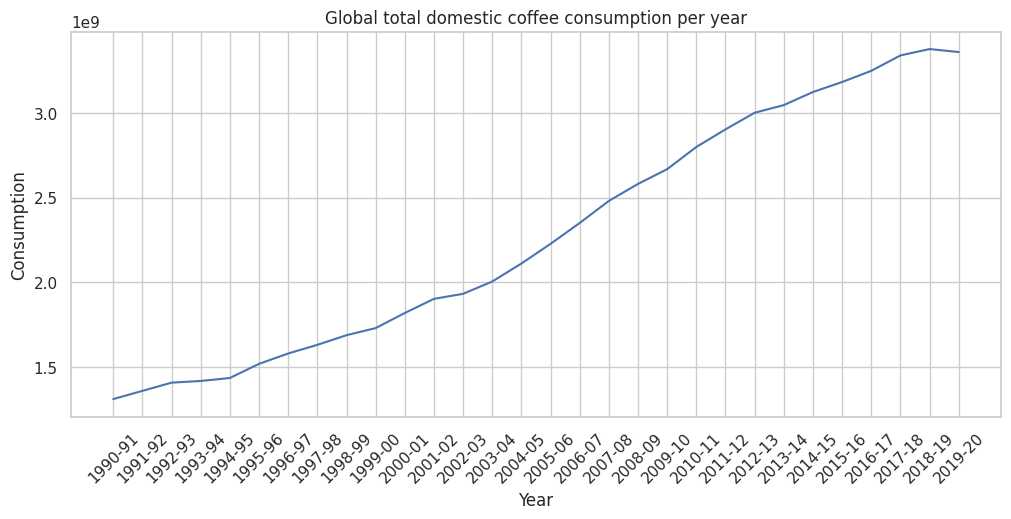

In [32]:
# Global trend chart
plt.figure(figsize=(12,5))
sns.lineplot(data=df_yearly, x="Year", y="Consumption")
plt.xticks(rotation=45)
plt.title("Global total domestic coffee consumption per year")
plt.show()

# Clean seaborn style
sns.set(style="whitegrid")  # using seaborn for a clean visual style


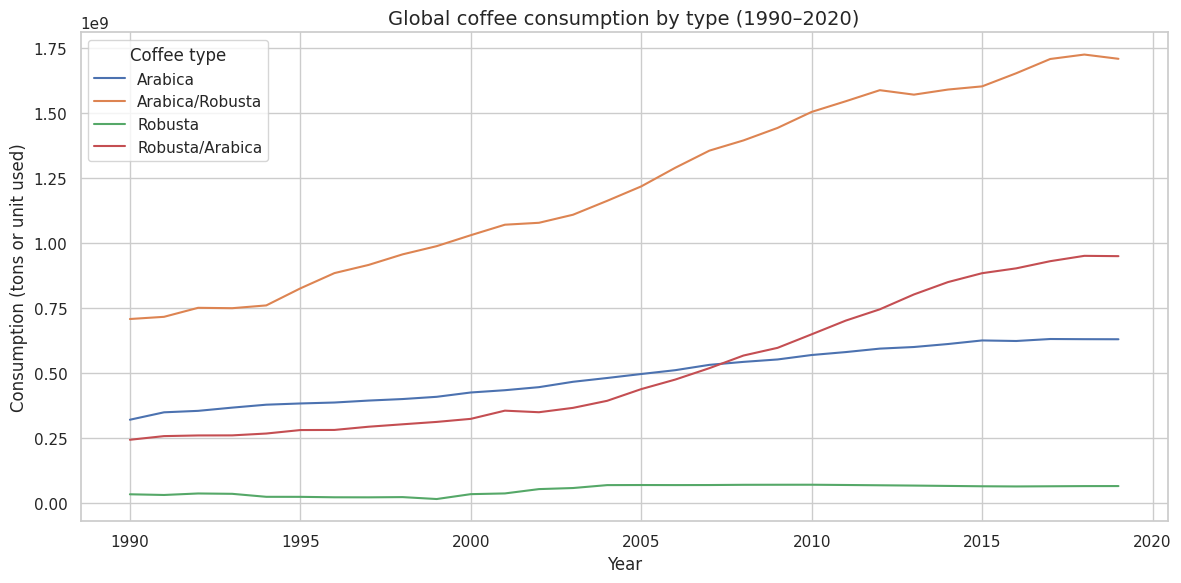

In [33]:
# Trend chart by coffee type
# If years are formatted like '1990-91', take only the first 4 characters
df["Year"] = df["Year"].astype(str).str[:4].astype(int)

# If there are multiple countries, group by year and coffee type
df_grouped = df.groupby(["Year", "Coffee type"], as_index=False)["Consumption"].sum()

# Create the line plot (no markers)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x="Year", y="Consumption", hue="Coffee type")

# Customize chart
plt.title("Global coffee consumption by type (1990–2020)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Consumption (tons or unit used)", fontsize=12)
plt.legend(title="Coffee type")
plt.tight_layout()
plt.show()

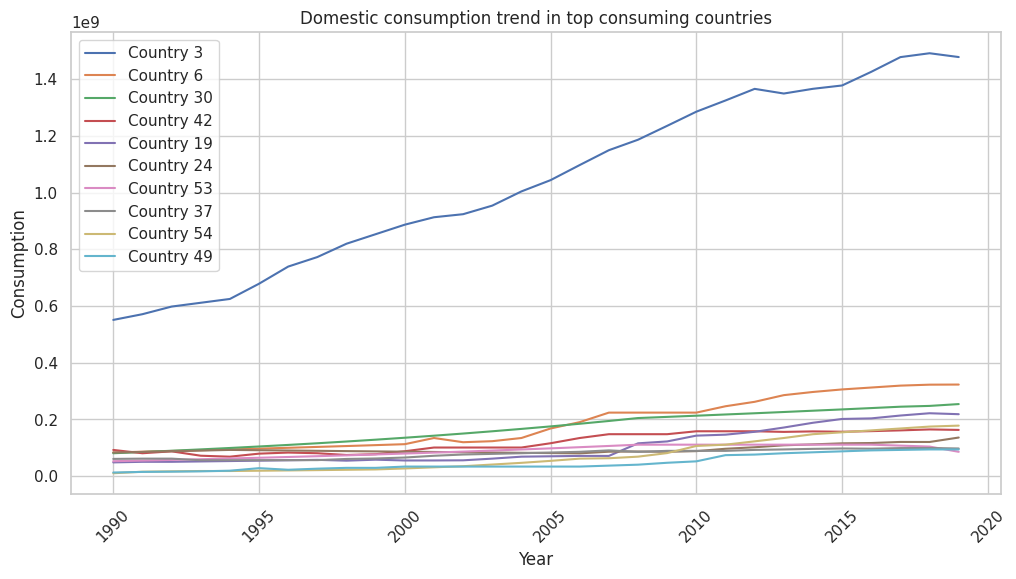

In [34]:
# Top 10 countries by total consumption
top_countries = df.groupby("Country")["Consumption"].sum().sort_values(ascending=False).head(10).index

plt.figure(figsize=(12,6))
for country in top_countries:
    subset = df[df["Country"] == country]
    sns.lineplot(data=subset, x="Year", y="Consumption", label=country)

plt.legend()
plt.xticks(rotation=45)
plt.title("Domestic consumption trend in top consuming countries")
plt.show()

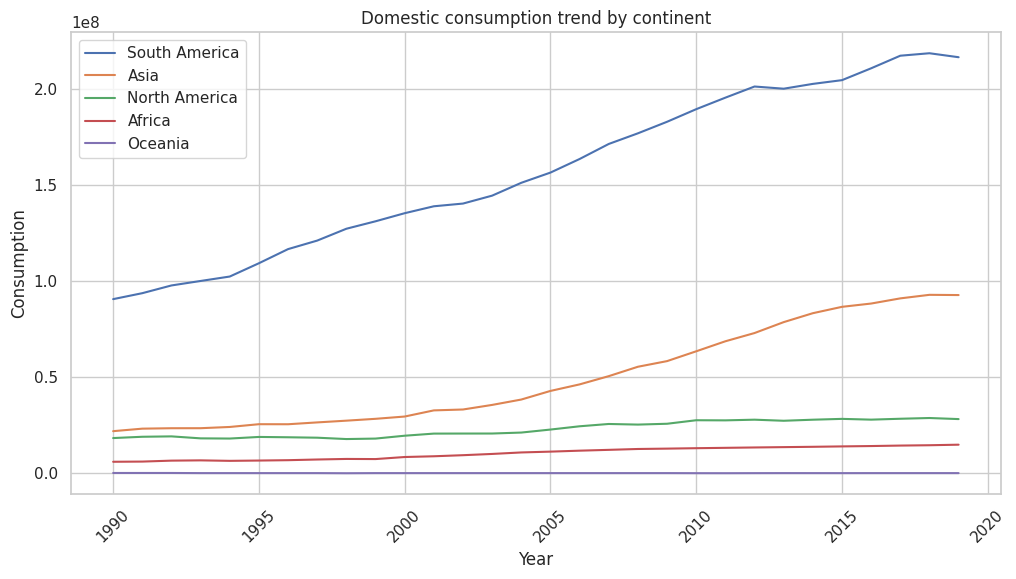

In [35]:
# Continents by total consumption
top_continents = df.groupby("Continent")["Consumption"].sum().sort_values(ascending=False).index

plt.figure(figsize=(12,6))
for continent in top_continents:
    subset = df[df["Continent"] == continent]
    sns.lineplot(data=subset, x="Year", y="Consumption", label=continent,ci=None)

plt.legend()
plt.xticks(rotation=45)
plt.title("Domestic consumption trend by continent")
plt.show()

In [36]:
# ---------------------------
# Sort by country and year
# ---------------------------
df_sorted = df.sort_values(by=["Country", "Year"])

# Calculate absolute and percentage change per country
df_sorted["Consumption_diff"] = df_sorted.groupby("Country")["Consumption"].diff()
df_sorted["Consumption_pct_change"] = df_sorted.groupby("Country")["Consumption"].pct_change() * 100

# Define threshold for abrupt change, e.g. +/-50%
threshold = 50

# Filter abrupt changes
abrupt_changes = df_sorted[df_sorted["Consumption_pct_change"].abs() > threshold]

# View abrupt changes (sorted by percent change)
abrupt_changes[["Country", "Year", "Consumption", "Consumption_diff", "Consumption_pct_change"]].sort_values(by="Consumption_pct_change", ascending=False)

,Country,Year,Consumption,Consumption_diff,Consumption_pct_change
1112,Country 13,2010,32928.0,32928.0,inf
769,Country 55,2003,9811200.0,9811200.0,inf
474,Country 35,1998,327062.4,327062.4,inf
699,Country 40,2002,10617600.0,10617600.0,inf
575,Country 26,2000,21280022.4,17920022.4,533.334000
129,Country 20,1992,1290240.0,1055040.0,448.571429
98,Country 44,1991,9273600.0,6988800.0,305.882353
1130,Country 31,2010,63638.4,46838.4,278.800000
781,Country 12,2004,67200.0,44822.4,200.300300
396,Country 12,1997,201600.0,134400.0,200.000000


In [37]:
# ---------------------------
# Data cleaning before growth metrics
# ---------------------------
# Step 1: Ensure years are ordered and consumption column is numeric
df["Year"] = df["Year"].astype(str)
df["Consumption"] = pd.to_numeric(df["Consumption"], errors="coerce")

# Step 2: Define a function to remove initial zeros per country
def remove_initial_zeros(group):
    # Find first index where consumption is greater than 0
    first_valid_index = group[group["Consumption"] > 0].index.min()
    # Return from that index onwards
    return group.loc[first_valid_index:]

# Step 3: Apply the function to each country
df_cleaned = df.sort_values(by=["Country", "Year"])
df_cleaned = df_cleaned.groupby("Country", group_keys=False).apply(remove_initial_zeros)

# Count zero-consumption entries per country
df_zeros = df[df["Consumption"] == 0].groupby("Country").size().sort_values(ascending=False)
df_zeros


,0
Country,
Country 29,30
Country 43,30
Country 13,20
Country 55,13
Country 40,12
Country 21,11
Country 35,8


In [38]:
# ---------------------------
# CAGR calculation helper
# ---------------------------
def compute_cagr(start, end, periods):
    if start > 0 and periods > 0:
        return ((end / start) ** (1 / periods)) - 1
    else:
        return None

# Build list to store CAGR results
cagr_results = []

# Group by country and compute CAGR
for country, group in df_cleaned.groupby("Country"):
    group_sorted = group.sort_values("Year")
    start = group_sorted["Consumption"].iloc[0]
    end = group_sorted["Consumption"].iloc[-1]
    years = len(group_sorted["Year"].unique()) - 1

    cagr = compute_cagr(start, end, years)

    if cagr is not None:
        cagr_results.append({
            "Country": country,
            "Start Year": group_sorted["Year"].iloc[0],
            "End Year": group_sorted["Year"].iloc[-1],
            "Start Consumption": start,
            "End Consumption": end,
            "Years": years,
            "CAGR (%)": round(cagr * 100, 2)  # Convert to percentage
        })

# Create DataFrame with CAGR results
cagr_df = pd.DataFrame(cagr_results)

# Sort by CAGR descending
cagr_df_sorted = cagr_df.sort_values(by="CAGR (%)", ascending=False)

# Show top 10 countries by CAGR
print(cagr_df_sorted.head(10))

       Country Start Year End Year  Start Consumption  End Consumption  Years  \
12  Country 20       1990     2019           268800.0     6.384000e+06     29   
47  Country 54       1990     2019         10080000.0     1.780800e+08     29   
41  Country 49       1990     2019         12633600.0     9.408000e+07     29   
18  Country 26       1990     2019          3360000.0     2.130240e+07     29   
36  Country 44       1990     2019          2284800.0     1.411200e+07     29   
10  Country 19       1990     2019         48384000.0     2.184000e+08     29   
49   Country 6       1990     2019         83462400.0     3.229632e+08     29   
45  Country 52       1990     2019          4704000.0     1.706880e+07     29   
22  Country 30       1990     2019         80640000.0     2.540832e+08     29   
21   Country 3       1990     2019        551040000.0     1.478400e+09     29   

    CAGR (%)  
12     11.54  
47     10.41  
41      7.17  
18      6.58  
36      6.48  
10      5.33  
49 

In [39]:
# Number of coffee types per country
variedades_por_pais = (
    df_cleaned.groupby("Country")["Coffee type"]
    .nunique()
    .reset_index(name="Num_Coffee_Types")
    .sort_values(by="Num_Coffee_Types", ascending=False)
)

# Show the table
print(variedades_por_pais)

       Country  Num_Coffee_Types
0    Country 1                 1
1   Country 10                 1
2   Country 11                 1
3   Country 12                 1
4   Country 13                 1
5   Country 14                 1
6   Country 15                 1
7   Country 16                 1
8   Country 17                 1
9   Country 18                 1
10  Country 19                 1
11   Country 2                 1
12  Country 20                 1
13  Country 21                 1
14  Country 22                 1
15  Country 23                 1
16  Country 24                 1
17  Country 25                 1
18  Country 26                 1
19  Country 27                 1
20  Country 28                 1
21   Country 3                 1
22  Country 30                 1
23  Country 31                 1
24  Country 32                 1
25  Country 33                 1
26  Country 34                 1
27  Country 35                 1
28  Country 36                 1
29  Countr

In [40]:
# Get the latest available year
ultimo_anio = df["Year"].max()

# Identify countries with consumption > 0 in the latest year
paises_activos = df[
    (df["Year"] == ultimo_anio) & (df["Consumption"] > 0)
]["Country"].unique()

# Filter original dataframe to active countries
df_activos = df[df["Country"].isin(paises_activos)]

**Data Quality**

Several countries were identified with consumption records equal to zero in the early years. These values were excluded from the analysis, as they likely correspond to periods prior to the actual start of exports to those countries. Countries whose entire time series consisted entirely of zeros were also removed.

**Consumption Distribution**

*   Global total consumption has shown an upward trend over the period.

*   Country 3 is by far the country with the highest coffee consumption within the group analyzed.

*   When analyzing by continent, South America leads in total accumulated consumption, followed by Asia, which has been increasing its share in recent years.


**Comparison by Coffee Type**

*   In all countries, only one coffee variety is reported.

*   The Arabica/Robusta variety has been the leader in consumption, and since 2008 the Robusta/Arabica variety has ranked second.


**Growth Analysis**

The Compound Annual Growth Rate (CAGR) was calculated for all countries. The countries with the highest growth in consumption during the 1990–2020 period include:

*   Country 20: +11.54%
*   Country 54: +10.41%
*   Country 49: +7.17%

These figures suggest opportunities for expansion in emerging markets with rapidly growing consumption.

On the other hand, a decline in consumption was observed for:

*   Country 32: -7.11%
*   Country 55: -5.02%
*   Country 21 is a country to which exports ceased in 2008.

In [41]:
df_activos.to_csv("df_cleaned.csv", index=False)